In [114]:
# 40,000 monthly limit requests to Directions API

In [1]:
# place = {"city": "Berkeley", "state": "California", "country": "USA"}
# G = ox.graph_from_place(place, network_type="drive")

In [2]:
# fig, ax = ox.plot_graph(G, node_size=0, dpi=600)

In [3]:
# pois = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
# X = pois.x
# Y = pois.y
#nn = ox.nearest_nodes(G, X, Y)

In [4]:
# ax = pois.to_crs(epsg=3857).plot(figsize=(20,20), alpha=1, markersize=100, edgecolor='red')
# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
# ax.set_axis_off()

In [1]:
# !conda install -c conda-forge gmaps -y
# !jupyter nbextension enable --py gmaps

# conda activate ox
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd
import contextily as cx
from shapely.prepared import prep
import shapely
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import cenpy as cp

!jupyter nbextension enable --py gmaps
with open('api_key.txt') as f:
    api_key = f.readline()
    f.close
import gmaps
gmaps.configure(api_key=api_key)
import googlemaps
from datetime import datetime
gmaps = googlemaps.Client(key=api_key)

/Users/sgangrade/opt/anaconda3/envs/ox/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK


## Pick a study location and download all the POIs in a 10-mile radius.

In [2]:
# Specify a study location (place)
place = {"city": "Berkeley", "state": "California", "country": "USA"}
# Get its centroid
place_centroid = ox.geocode_to_gdf(place).to_crs('+proj=cea').centroid.to_crs('EPSG:4326')
# Specify POI type(s)
tags = {"amenity": ["fast_food", "marketplace"], "shop": ["convenience", "grocery", "supermarket", "farm"], "social_facility": ["food_bank", "soup_kitchen"], "leisure": ["garden:type=community"]} # {"amenity": "fast_food", "shop": "convenience"}
# Download POIs
pois = ox.geometries.geometries_from_point((place_centroid[0].y, place_centroid[0].x), tags, dist=10*1609).reset_index()
# fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))
pois['geometry'] = pois['geometry'].to_crs('+proj=cea').centroid.to_crs('EPSG:4326')
pois

,element_type,osmid,brand,brand:wikidata,brand:wikipedia,name,shop,website,geometry,addr:city,...,comments,building_1,building_2,layer,historic,historic:alt_name,historic:name,wholesale,ways,type
0,node,212435197,Trader Joe's,Q688825,en:Trader Joe's,Trader Joe's,supermarket,https://locations.traderjoes.com/ca/oakland/231/,POINT (-122.25261 37.84554),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,286081303,NaN,NaN,NaN,Shattuck Market,supermarket,https://shattuck-market.business.site,POINT (-122.26711 37.86503),Berkeley,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,286632462,Jamba,Q3088784,en:Jamba Juice,Jamba Juice,NaN,https://www.jamba.com/ca/berkeley/bancroft-150,POINT (-122.25877 37.86861),Berkeley,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,288991105,NaN,NaN,NaN,Nation's Giant Hamburgers,NaN,http://www.nationsrestaurants.com/,POINT (-122.27484 37.87095),Berkeley,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,293632937,Safeway,Q1508234,en:Safeway Inc.,Safeway,supermarket,https://local.safeway.com/ca/san-francisco-260...,POINT (-122.39423 37.77674),San Francisco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,way,1097621739,NaN,NaN,NaN,Oakland Produce Market,NaN,NaN,POINT (-122.27483 37.79604),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,food,NaN,NaN
1393,way,1105289817,NaN,NaN,NaN,The Market,supermarket,https://www.visitthemarket.com/,POINT (-122.41681 37.77654),San Francisco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1394,way,1108103084,NaN,NaN,NaN,Kensington Farmer's Market,NaN,http://www.kensingtonfarmersmarket.org/,POINT (-122.28764 37.89943),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1395,relation,3474418,Chevron,Q319642,en:Chevron Corporation,Chevron,convenience,NaN,POINT (-122.40335 37.74682),San Francisco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[258866759, 258866761]",multipolygon


Note that we have columns "shop", "amenity", "marketplace", etc.

## Create a grid of points/locations for mapping analysis.

262 neighborhoods


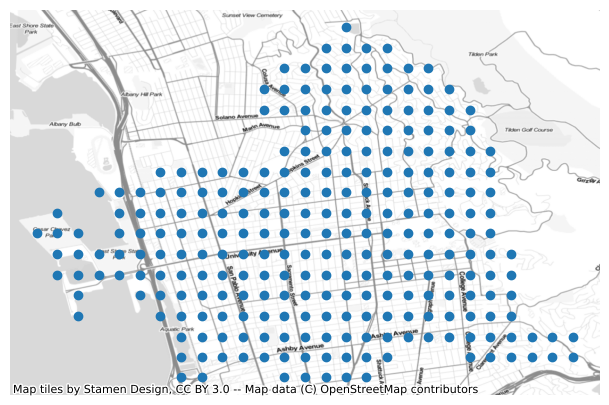

In [8]:
gdf_place = ox.geocode_to_gdf(place)

# determine maximum edges
polygon = gdf_place['geometry'][0]
latmin, lonmin, latmax, lonmax = polygon.bounds
resolution = 1/300

# create prepared polygon
prep_polygon = prep(polygon)

# construct a rectangular mesh
points = []
for lat in np.arange(latmin, latmax, resolution):
    for lon in np.arange(lonmin, lonmax, resolution):
        points.append(shapely.geometry.Point((round(lat,4), round(lon,4))))
valid_points = []
valid_points.extend(filter(prep_polygon.contains, points))
        
# Create list of points that lie within specified city.
neighborhoods = [(p.y, p.x) for p in valid_points]

nbhd_points = gpd.GeoDataFrame(geometry=[shapely.geometry.Point(n) for n in 
                  [(x, y) for x,y in zip([n[1] for n in neighborhoods], 
                                         [n[0] for n in neighborhoods])
                  ]
                 ],
                crs='EPSG:4326')
# Remove points in the water.
water_polygons = ox.geometries.geometries_from_place(place, tags={"natural": "bay"})
nbhd_points = nbhd_points[gpd.tools.sjoin(nbhd_points, water_polygons, predicate="within", how='left')['index_right0'].isna()].reset_index(drop=True)
neighborhoods = nbhd_points['geometry'].tolist()
print(len(neighborhoods), 'neighborhoods')

ax = nbhd_points.plot(figsize=(10, 5));
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs='EPSG:4326');
ax.set_axis_off();

In [30]:
pois_grocery_supermarket = pois[(pois['shop']=='grocery') | (pois['shop']=='supermarket')].reset_index()

In [31]:
pois_fastfood_convenience = pois[(pois['shop']=='convenience') | (pois['amenity']=='fast_food')].reset_index()

In [67]:
buffered_nbhd_points = nbhd_points.buffer(5*resolution)

/var/folders/fb/qs7d795s4mz5dfcd2xc5h8n80000gn/T/ipykernel_13332/2522852525.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_nbhd_points = nbhd_points.buffer(5*resolution)


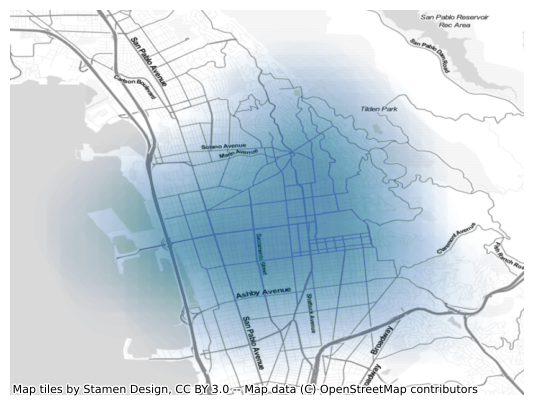

In [69]:
ax = buffered_nbhd_points.plot(figsize=(10, 5), alpha=0.01);
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs='EPSG:4326');
ax.set_axis_off();

In [70]:
neighborhoods_contain_pois = pd.DataFrame([[buffered_nbhd_points[i].contains(pois.geometry[j]) for j in range(len(pois.geometry)) ] for i in range(len(buffered_nbhd_points))])

In [71]:
neighborhoods_contain_grocery_supermarket = pd.DataFrame([[buffered_nbhd_points[i].contains(pois_grocery_supermarket.geometry[j]) for j in range(len(pois_grocery_supermarket.geometry)) ] for i in range(len(buffered_nbhd_points))])

In [72]:
neighborhoods_contain_fastfood_convenience = pd.DataFrame([[buffered_nbhd_points[i].contains(pois_fastfood_convenience.geometry[j]) for j in range(len(pois_fastfood_convenience.geometry)) ] for i in range(len(buffered_nbhd_points))])

Grocery Count

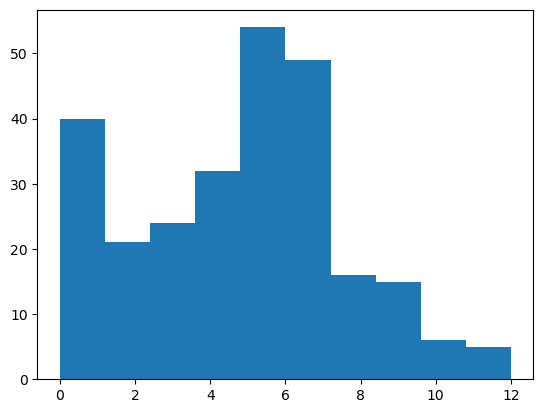

In [74]:
grocery_supermarket_counts = neighborhoods_contain_grocery_supermarket.sum(axis=1)
plt.hist(grocery_supermarket_counts);

FF/Convenience Count

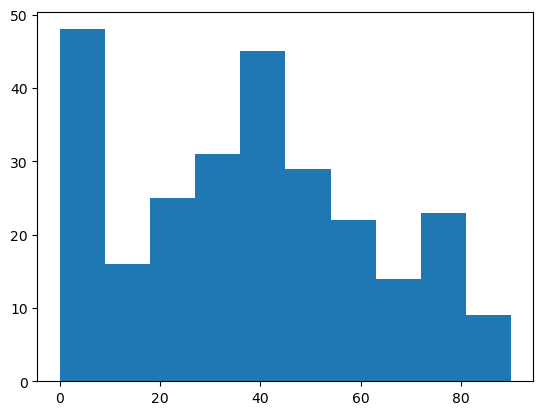

In [75]:
fastfood_convenience_counts = neighborhoods_contain_fastfood_convenience.sum(axis=1)
plt.hist(fastfood_convenience_counts);

Nearest Neighbor

In [76]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [77]:
nbhd_points_nearest_grocery_supermarket = ckdnearest(nbhd_points, pois_grocery_supermarket)[['geometry','osmid']]
nbhd_points_nearest_grocery_supermarket = pd.merge(nbhd_points_nearest_grocery_supermarket, pois_grocery_supermarket, how='left', on='osmid')
nbhd_points_nearest_grocery_supermarket.sample(5)

,geometry_x,osmid,index,element_type,brand,brand:wikidata,brand:wikipedia,name,shop,website,...,comments,building_1,building_2,layer,historic,historic:alt_name,historic:name,wholesale,ways,type
63,POINT (-122.29200 37.88240),134483637,1199,way,NaN,NaN,NaN,Berkeley Natural Grocery,grocery,http://naturalgrocery.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,POINT (-122.30870 37.87240),2475998084,346,node,NaN,NaN,NaN,Market Hall Foods,supermarket,https://www.markethallfoodson4th.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,POINT (-122.26530 37.87570),310635103,1311,way,Safeway,Q1508234,en:Safeway Inc.,Andronico's,supermarket,https://local.andronicos.com/ca/berkeley/1550-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,POINT (-122.28200 37.86570),910883497,120,node,NaN,NaN,NaN,Mi Tierra,supermarket,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,POINT (-122.30530 37.86910),2475998084,346,node,NaN,NaN,NaN,Market Hall Foods,supermarket,https://www.markethallfoodson4th.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
nbhd_points_nearest_fastfood_convenience = ckdnearest(nbhd_points, pois_fastfood_convenience)[['geometry','osmid']]
nbhd_points_nearest_fastfood_convenience = pd.merge(nbhd_points_nearest_fastfood_convenience, pois_fastfood_convenience, how='left', on='osmid')
nbhd_points_nearest_fastfood_convenience.sample(5)

,geometry_x,osmid,index,element_type,brand,brand:wikidata,brand:wikipedia,name,shop,website,...,comments,building_1,building_2,layer,historic,historic:alt_name,historic:name,wholesale,ways,type
84,POINT (-122.28530 37.89240),8787289254,981,node,NaN,NaN,NaN,Fillgood,convenience,https://www.fillgood.co/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,POINT (-122.26530 37.88910),314115417,11,node,NaN,NaN,NaN,Mexicana Taqueria,NaN,https://www.mexicanataqueria.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,POINT (-122.25870 37.88910),2408078512,339,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,POINT (-122.25870 37.85910),7940287676,929,node,Krispy Krunchy Chicken,Q65087447,en:Krispy Krunchy Chicken,Krispy Krunchy Chicken,NaN,https://www.krispykrunchy.com/locations/store-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,POINT (-122.24530 37.86570),9347384618,1023,node,NaN,NaN,NaN,End Zone Grill,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Travel Time

In [82]:
def get_directions(origin_geom, destination_geom, mode='transit', departure_time=datetime(2022, 12, 3, 12, 0, 0, 0)):
    directions_results = gmaps.directions(origin=(origin_geom.y, origin_geom.x), 
                                          destination=(destination_geom.y, destination_geom.x),
                                          mode=mode,
                                          departure_time=departure_time
                                         )
    distance = directions_results[0]['legs'][0]['distance']['value']
    duration = directions_results[0]['legs'][0]['duration']['value']
    return distance, duration

In [83]:
grocery_routing_results = [get_directions(nbhd_points_nearest_grocery_supermarket.geometry_x[i], nbhd_points_nearest_grocery_supermarket.geometry_y[i]) for i in range(len(nbhd_points_nearest_grocery_supermarket))]

In [84]:
fastfood_convenience_routing_results = [get_directions(nbhd_points_nearest_fastfood_convenience.geometry_x[i], nbhd_points_nearest_fastfood_convenience.geometry_y[i]) for i in range(len(nbhd_points_nearest_fastfood_convenience))]

In [86]:
# routing_results = [get_directions(nbhd_points_nn.geometry_x[i], nbhd_points_nn.geometry_y[i]) for i in range(len(nbhd_points_nn))]

In [14]:
# routing_results_df = pd.DataFrame(columns=['distance', 'duration'], data=np.array(routing_results))

In [88]:
grocery_routing_results_df = pd.DataFrame(columns=['distance', 'duration'], data=np.array(grocery_routing_results))
fastfood_convenience_routing_results_df = pd.DataFrame(columns=['distance', 'duration'], data=np.array(fastfood_convenience_routing_results))

In [89]:
dist_dur_grocery_df = nbhd_points_nearest_grocery_supermarket.join(grocery_routing_results_df)
dist_dur_fastfood_convenience_df = nbhd_points_nearest_fastfood_convenience.join(fastfood_convenience_routing_results_df)

In [91]:
dist_dur_grocery_df.sample(5)

,geometry_x,osmid,index,element_type,brand,brand:wikidata,brand:wikipedia,name,shop,website,...,building_2,layer,historic,historic:alt_name,historic:name,wholesale,ways,type,distance,duration
78,POINT (-122.28530 37.86570),910883497,120,node,NaN,NaN,NaN,Mi Tierra,supermarket,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,840,627
1,POINT (-122.31870 37.86570),2475998084,346,node,NaN,NaN,NaN,Market Hall Foods,supermarket,https://www.markethallfoodson4th.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2826,1203
161,POINT (-122.26870 37.87910),310635103,1311,way,Safeway,Q1508234,en:Safeway Inc.,Andronico's,supermarket,https://local.andronicos.com/ca/berkeley/1550-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148,127
88,POINT (-122.28200 37.85570),52769190,1169,way,NaN,NaN,NaN,Berkeley Bowl West,supermarket,https://www.berkeleybowl.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,888,654
251,POINT (-122.24530 37.85570),2487652502,348,node,Safeway,Q1508234,en:Safeway Inc.,Safeway,supermarket,https://local.safeway.com/safeway/ca/oakland/6...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1144,542


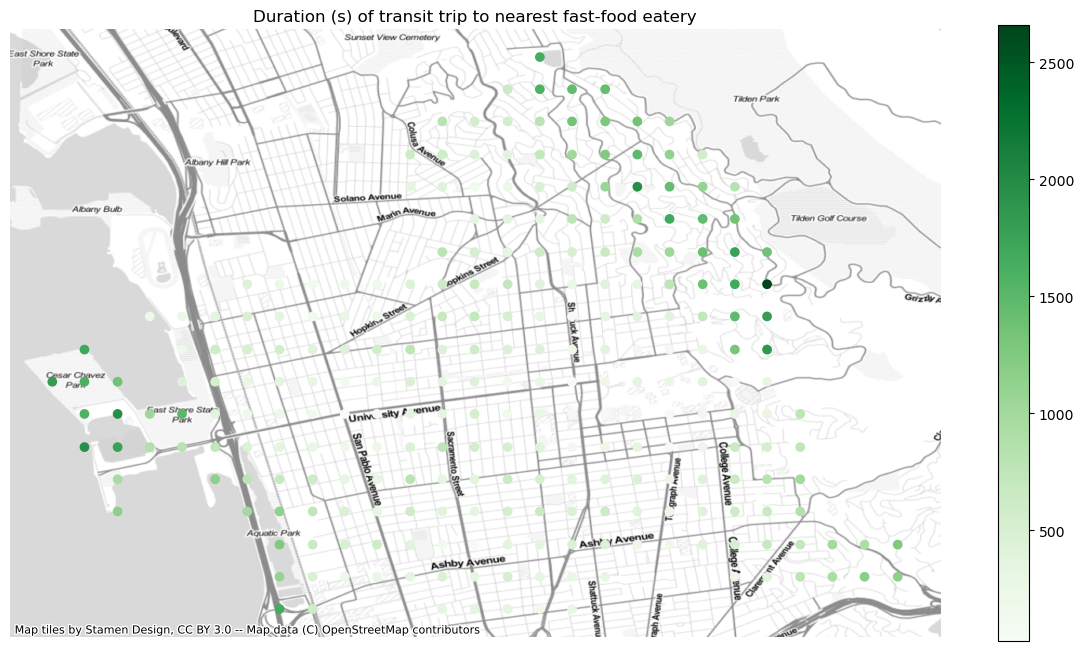

In [20]:
import matplotlib.pyplot as plt
plot_df = dist_dur_df[['geometry_x', 'duration']].set_geometry('geometry_x')
ax = plot_df.plot(figsize=(15, 8), column='duration', cmap = 'Greens', legend=True);
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=plot_df.crs);
ax.set_axis_off();
plt.title('Duration (s) of transit trip to nearest fast-food eatery');

In [23]:
acs = cp.products.ACS()

In [24]:
place_acs = acs.from_county('Alameda, CA', level='tract', variables=['B01003_001E', # population
                                                                     'B06011_001E', # median income 
                                                                    ]
                            ).to_crs('EPSG:4326')
place_acs = place_acs.rename(columns={'B06011_001E':'med_income'})

/Users/sgangrade/opt/anaconda3/envs/ox/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/sgangrade/opt/anaconda3/envs/ox/lib/python3.10/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)


In [25]:
pop_density = place_acs['B01003_001E']/place_acs.to_crs('EPSG:3857').area

In [26]:
place_acs['density'] = pop_density

In [27]:
in_tract = pd.DataFrame([[place_acs.geometry[i].contains(dist_dur_df.geometry_x[j]) for j in range(len(dist_dur_df)) ] for i in range(len(place_acs))]).T

In [28]:
y = [None] * len(in_tract)
for x in range(len(in_tract)):
    for n in range(len(in_tract.iloc[x])):
        if in_tract.iloc[x][n] == True:
            y[x] = n

In [29]:
dist_dur_df['tract_index'] = y

In [30]:
dist_dur_density_df = pd.merge(dist_dur_df, place_acs.reset_index()[['index','density','med_income']], left_on='tract_index', right_on='index', how='inner')

In [31]:
dist_dur_density_df['duration * density'] = dist_dur_density_df['duration'] * dist_dur_density_df['density']
dist_dur_density_df['duration * density / income'] = dist_dur_density_df['duration * density'] / dist_dur_density_df['med_income']

/var/folders/fb/qs7d795s4mz5dfcd2xc5h8n80000gn/T/ipykernel_25191/1012806272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['duration * density'][plot_df['duration * density'] > q_85] = q_85


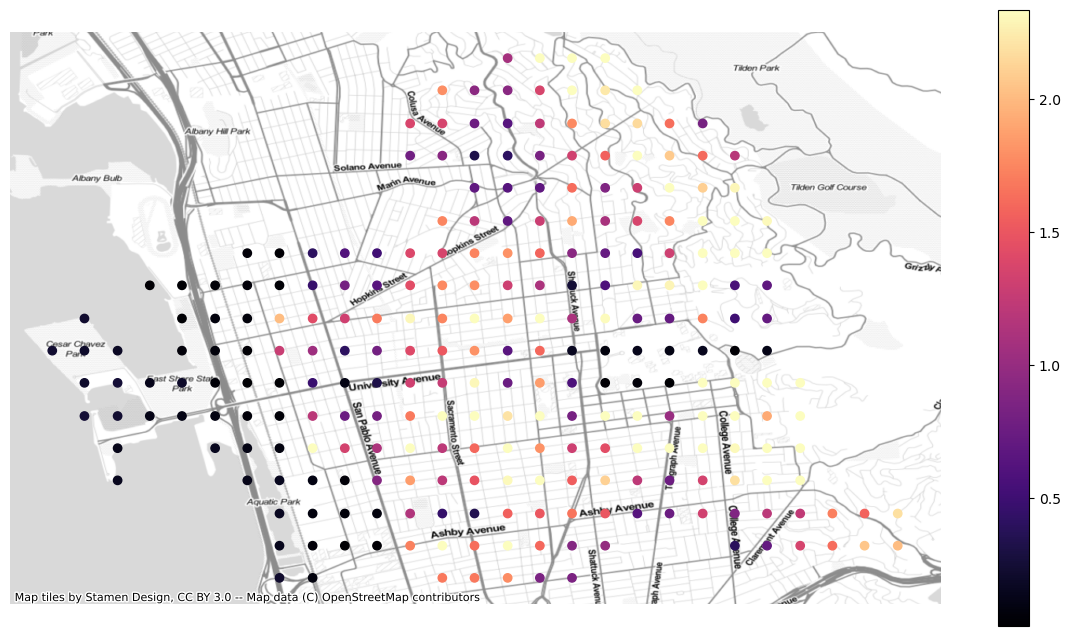

In [32]:
plot_df = dist_dur_density_df[['geometry_x', 'duration * density']].set_geometry('geometry_x')

# Taper after 85th percentile
q_85 = np.nanpercentile(plot_df['duration * density'], 85)
plot_df['duration * density'][plot_df['duration * density'] > q_85] = q_85

ax = plot_df.plot(figsize=(15, 8), column='duration * density', cmap = 'magma', legend=True);
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=plot_df.crs);
ax.set_axis_off();
#plt.title(r"Duration (s) of transit trip to nearest fast-food eatery $\times$ population density (pax/m$^2$)");

/var/folders/fb/qs7d795s4mz5dfcd2xc5h8n80000gn/T/ipykernel_25191/4262301870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['duration * density / income'][plot_df['duration * density / income'] > q_85] = q_85


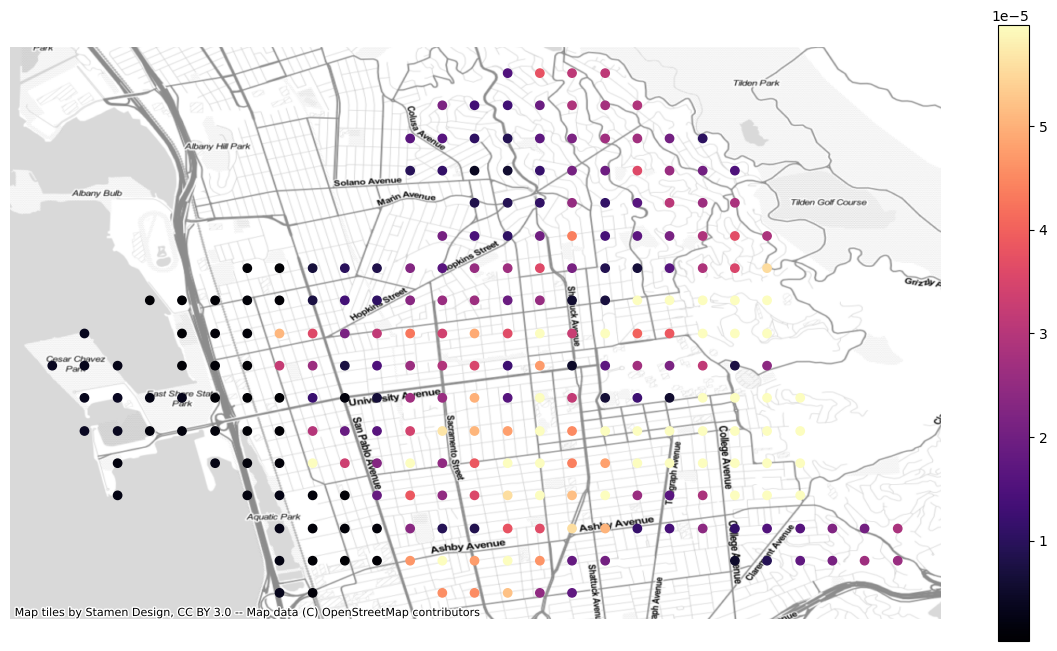

In [33]:
plot_df = dist_dur_density_df[['geometry_x', 'duration * density / income']].set_geometry('geometry_x')

# Taper after 85th percentile
q_85 = np.nanpercentile(plot_df['duration * density / income'], 85)
plot_df['duration * density / income'][plot_df['duration * density / income'] > q_85] = q_85

ax = plot_df.plot(figsize=(15, 8), column='duration * density / income', cmap = 'magma', legend=True);
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=plot_df.crs);
ax.set_axis_off();
#plt.title(r"Duration (s) of transit trip to nearest fast-food eatery $\times$ population density (pax/m$^2$) / median income (USD)");

## Archive

In [ ]:
def dirs_from_nbhd_to_poi(nbhd, pois, mode="transit", departure_time=datetime.now()):
    """
    Returns the distances and durations FROM the provided point location TO all the POIs in pois.
    """
    directions_results = [0]*len(pois)
    distances = [0]*len(pois)
    durations = [0]*len(pois)
    for i in range(len(pois)):
            directions_results[i] = gmaps.directions(origin=nbhd,
                                                     destination=(pois.iloc[i]['geometry'].y, pois.iloc[i]['geometry'].x), # lat, lon
                                                     mode=mode, # "driving", "walking", "bicycling" or "transit"
                                                     departure_time=departure_time
                                                       )
            distances[i] = directions_results[i][0]['legs'][0]['distance']['value']
            durations[i] = directions_results[i][0]['legs'][0]['duration']['value']
    return distances, durations

In [8]:
pois_per_neighborhood = [0]*len(neighborhoods)
tick = 0
for n in range(len(neighborhoods)):
    pois_per_neighborhood[n] = ox.geometries.geometries_from_point(neighborhoods[n], tags, dist=1*1609) # 1 miles
    pois_per_neighborhood[n].reset_index(inplace=True)
    clear_output(wait=True)
    tick += 1
    print(round(100 * tick / len(neighborhoods)), "%")

100 %


In [9]:
def only_keep_points(gdf):
    if pois_per_neighborhood[0].empty:
        return gdf
    return gdf[gdf['element_type']=='node']

def dirs_from_nbhd_to_poi(nbhd, pois, mode="transit", departure_time=datetime.now()):
    """
    Returns the distances and durations FROM the provided point location TO all the POIs in pois.
    """
    directions_results = [0]*len(pois)
    distances = [0]*len(pois)
    durations = [0]*len(pois)
    for i in range(len(pois)):
            directions_results[i] = gmaps.directions(origin=nbhd,
                                                     destination=(pois.iloc[i]['geometry'].y, pois.iloc[i]['geometry'].x), # lat, lon
                                                     mode="transit", # "driving", "walking", "bicycling" or "transit"
                                                     departure_time=departure_time
                                                       )
            distances[i] = directions_results[i][0]['legs'][0]['distance']['value']
            durations[i] = directions_results[i][0]['legs'][0]['duration']['value']
    return distances, durations

In [10]:
tick = 0
distances = [0]*len(neighborhoods)
durations = [0]*len(neighborhoods)
for n in range(len(neighborhoods)):
    pois_per_neighborhood[n] = only_keep_points(pois_per_neighborhood[n])
    distances[n], durations[n] = dirs_from_nbhd_to_poi(neighborhoods[n], 
                                             pois_per_neighborhood[n], 
                                             "transit", 
                                             datetime.now())
    clear_output(wait=True)
    tick += 1
    print(round(100 * tick / len(neighborhoods)), "%")

100 %


In [11]:
dist_dur = [0] * len(neighborhoods)
for n in range(len(neighborhoods)):
    dist_dur[n] = gpd.GeoDataFrame(data={"element_type": pois_per_neighborhood[n]['element_type'], 
                                         "osmid": pois_per_neighborhood[n]['osmid'], 
                                         "distance (m)": distances[n], 
                                         "duration (s)": durations[n]
                                        }, 
                                   geometry=pois_per_neighborhood[n].geometry
                                  )

In [17]:
dist_dur[0]

,element_type,osmid,distance (m),duration (s),geometry
0,node,212435197,11289,4198,POINT (-122.25261 37.84554)
1,node,286081303,7841,3353,POINT (-122.26711 37.86503)
2,node,343317788,8406,3420,POINT (-122.29957 37.89885)
3,node,363915431,16209,5718,POINT (-122.24438 37.80991)
4,node,410243509,15722,4936,POINT (-122.26500 37.80272)
5,node,477131697,8934,3708,POINT (-122.30714 37.89865)
6,node,612767884,29312,6330,POINT (-122.40900 37.79867)
7,node,732040844,30194,6654,POINT (-122.41289 37.80644)
8,node,775881481,6588,2876,POINT (-122.27322 37.87170)
9,node,910883477,4678,2298,POINT (-122.29451 37.86834)


In [21]:
mean_distance_per_neighborhood = [df['distance (m)'].mean() for df in dist_dur]
mean_duration_per_neighborhood = [df['duration (s)'].mean() for df in dist_dur]
print(mean_distance_per_neighborhood)
print(mean_duration_per_neighborhood)

[15201.951219512195, 7588.941176470588, 6961.5, 9594.142857142857]
[4661.317073170731, 2223.235294117647, 1389.0882352941176, 2784.9523809523807]


In [107]:
lon = [n[1] for n in neighborhoods]
lat = [n[0] for n in neighborhoods]
nbhd_lon_lat = [(x, y) for x,y in zip(lon, lat)]
summary_gdf = gpd.GeoDataFrame(data = {'mean distance (m)': mean_distance_per_neighborhood,
                                       'mean duration (s)': mean_duration_per_neighborhood},
                               geometry = [shapely.geometry.Point(n) for n in nbhd_lon_lat],
                               crs = 'epsg:4326'
                              ).to_crs('epsg:3857')
del lon, lat, nbhd_lon_lat

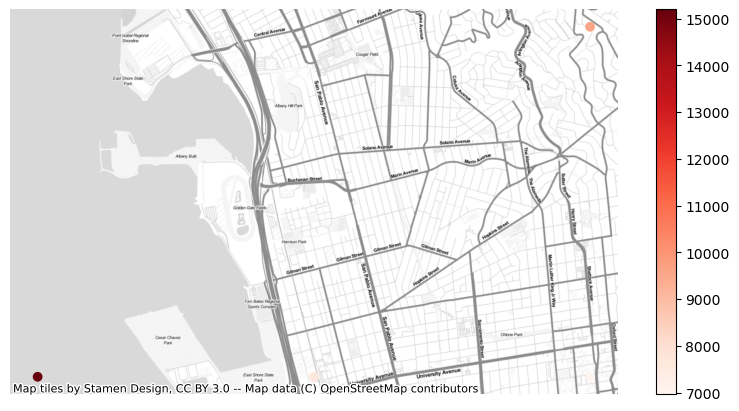

In [113]:
import matplotlib.pyplot as plt

# ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# ax.set_axis_off()
ax = summary_gdf.plot(figsize=(10, 5), column='mean distance (m)', cmap = 'Reds', legend=True);
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=summary_gdf.crs);
ax.set_axis_off();